In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [23]:
import numpy as np
import pandas as pd

In [24]:
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import join, outerjoin, MetaData
from sqlalchemy import Table, Column, Integer, String, Float

In [26]:
# Connect to database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()
meta = MetaData()
# Create an inspector and connect it to the engine
inspector = inspect(engine)
# dir(inspector)
# View table names
tables = inspector.get_table_names()
tables

['measurement', 'station']

In [27]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
tables = Base.classes.keys()

In [28]:
# We can view all of the classes that automap found
tables

['measurement', 'station']

In [29]:
# Save references to each table
Measurement = Base.classes['measurement']
Station = Base.classes['station']
# dir(Station)
# dir(Measurement)

In [30]:
# Create our session (link) from Python to the DB
session = Session(engine)
session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).first()

('USC00519397', '2010-01-01', 0.08, 65.0)

In [31]:
session.query(Station.station, Station.name).all()

[('USC00519397', 'WAIKIKI 717.2, HI US'),
 ('USC00513117', 'KANEOHE 838.1, HI US'),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00517948', 'PEARL CITY, HI US'),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US'),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00519281', 'WAIHEE 837.5, HI US'),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US')]

# Exploratory Climate Analysis

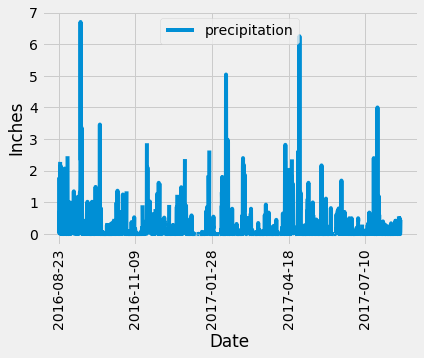

In [32]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find the end date for the data in Measurement

end_date_1 = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
end_date_1

# Calculate the date 1 year ago from the last data point in the database

end_date = dt.date(2017, 8, 23)
year_days = dt.timedelta(365)
begin_date = end_date - year_days

# Perform a query to retrieve the data and precipitation scores

hawaii_data_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=begin_date)

# Save the query results as a Pandas DataFrame and set the index to the date column

hawaii_data_year_df = pd.read_sql(hawaii_data_year.statement, conn)

hawaii_data_year_df = hawaii_data_year_df.set_index('date')

# Sort the dataframe by date

hawaii_data_year_df = hawaii_data_year_df.sort_values(by="date")

hawaii_data_year_df.head(100)

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_data_year_df = hawaii_data_year_df.rename(columns = {'prcp':'precipitation'})
hawaii_data_year_df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.show()

In [33]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_data_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [34]:
# Design a query to show how many stations are available in this dataset?

stations_count = session.query(Measurement.station).group_by(Measurement.station).count()
print(f"There are {stations_count} stations in this dataset.")

There are 9 stations in this dataset.


In [35]:
# What are the most active stations? (i.e. what stations have the most rows)?

most_active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                      .group_by(Measurement.station).order_by(func.count(Measurement.station).desc())

# List the stations and the counts in descending order.

for row in most_active_stations:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_id = 'USC00519281' # most active station id from above

low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station==station_id).first()
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station==station_id).first()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station==station_id).first()

print(f"Station ID = {station_id}\n\
Low Temp = {low_temp[0]}\n\
High Temp = {high_temp[0]}\n\
Avg Temp = {avg_temp[0]}")


Station ID = USC00519281
Low Temp = 54.0
High Temp = 85.0
Avg Temp = 71.66378066378067


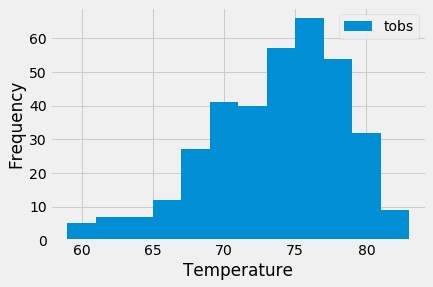

In [37]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query to find end date for Station ID USC00519281
enddate = session.query(Measurement.date).filter(Measurement.station==station_id)\
            .order_by(Measurement.date.desc()).first()

# Set end_date equal to enddate from query above
# Calculate the date 1 year ago from the last data point in the database

end_date = dt.date(2017, 8, 18)
year_days = dt.timedelta(365)
begin_date = end_date - year_days

# Query the last 12 months of tobs data for Station ID USC00519281 

tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).filter(Measurement.station\
                    == station_id).filter(Measurement.date >= begin_date).order_by(Measurement.date).all()

# Create DataFrame from query

tobs_df = pd.DataFrame(tobs)

# Histogram Plot
plt.hist(tobs_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"], loc="best")
plt.show()



In [38]:
# Temperature Analysis I
# June Average Temperature
june_averages = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "06").first()


# December Average Temperature
dec_averages = session.query(func.avg(Measurement.tobs)).\
    filter(func.strftime("%m", Measurement.date) == "12").first()


#print(f"There are {stations_count} stations in this dataset.")

print(f"Monthly Average Temperatures\n\
June = {june_averages[0]}\n\
December = {dec_averages[0]}")

Monthly Average Temperatures
June = 74.94411764705882
December = 71.04152933421226


In [59]:
# Unpaired T test (because we have two independent samples.)

# June has 1700 rows while December has 1517 rows.  Limit June rows to 1517.
june_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "06").all()
june_temps

dec_temps = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == "12").all()
dec_temps

t_test_up = stats.ttest_ind(june_temps,dec_temps, equal_var = False)
t_test_up

Ttest_indResult(statistic=array([31.35503692]), pvalue=array([4.19352984e-187]))

## Bonus Challenge Assignment

In [91]:
# Temperature Analysis II
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [92]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# function usage example
print(calc_temps('2014-08-10', '2014-08-19'))

[(68.0, 76.22535211267606, 83.0)]


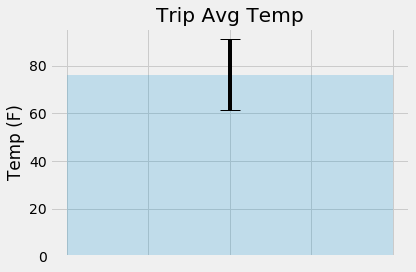

In [93]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Create lists for the plot
x_pos = 0
tavg = 76.23
tmin = 68.0
tmax = 83.0
error = tmax-tmin

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, tavg, yerr=error, align='center', alpha=0.2, ecolor='black', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp')

labels = [item.get_text() for item in ax.get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax.set_xticklabels(empty_string_labels)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
